# Processing of SCIP features

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [ ]:
from umap import UMAP
import time
import math
import pyarrow.parquet as pq
import pyarrow
from ehv import masking
from ehv.core import plot_gate_czi

## SCIP computed features

In [7]:
import os
os.environ["VSC_DATA_VO_USER"]

'/data/gent/vo/000/gvo00070/vsc42015'

In [84]:
df = pandas.concat([
    pq.read_table(p).to_pandas()
    for p in Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/results/scip/202112151458/").glob("*.parquet")
], axis=0)
df = df.reset_index(drop=True)

In [104]:
df = pq.read_table("/data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/results/scip/202112151458/features.parquet").to_pandas()

In [105]:
df.shape

(136951, 1290)

In [106]:
df["meta_path"] = df["meta_path"].map(lambda a: "/data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/" + os.path.basename(a))

In [87]:
pq.write_table(pyarrow.Table.from_pandas(df), "/data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/results/scip/202112151458/features.parquet")

## NaN filter

In [107]:
# images that have no bounding box
df = df[~df.filter(regex="bbox").isna().any(axis=1)]
df.shape

(136951, 1290)

In [108]:
df = df.drop(columns=df.columns[df.isna().all(axis=0)])
df.shape

(136951, 1290)

In [109]:
cols = df.filter(regex="glcm").columns[df.filter(regex="glcm").isna().any()]
df = df.drop(columns=cols)
df.shape

(136951, 1290)

In [110]:
cols = df.filter(regex="feat").columns[df.filter(regex="feat").isna().any()]
df = df.drop(columns=cols)
df.shape

(136951, 1290)

# Number of identified regions per channel 

/scratch/leuven/420/vsc42015/miniconda3/envs/analysis/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


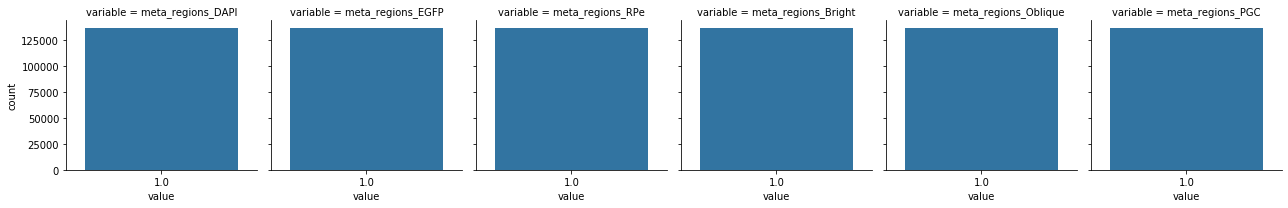

In [112]:
tmp = pandas.melt(df, value_vars=df.filter(regex="regions").columns)
tmp["value"] = tmp["value"].astype("category")
grid = seaborn.FacetGrid(data=tmp, col="variable")
grid.map_dataframe(seaborn.countplot, x="value")

# Detecting multiplets that are missed during segmentation

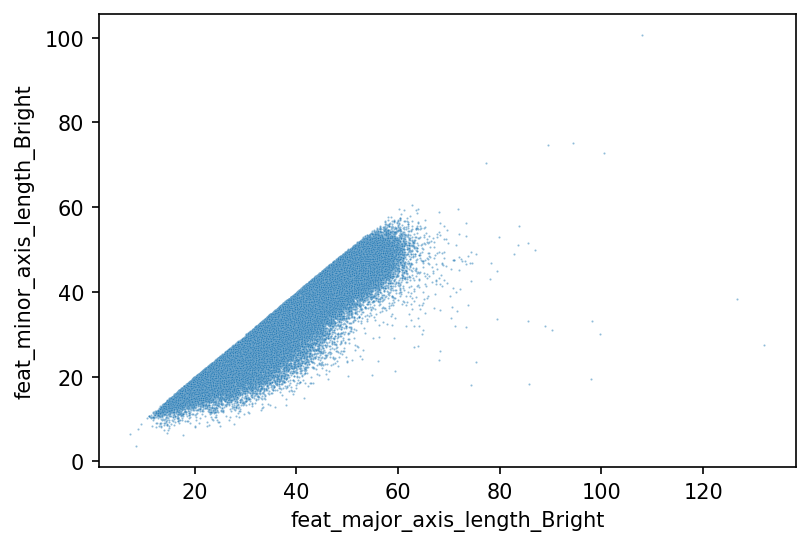

In [115]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(ax=ax, data=df, x="feat_major_axis_length_Bright", y="feat_minor_axis_length_Bright", s=1, alpha=0.5)

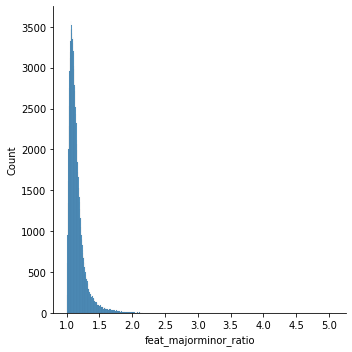

In [117]:
df["feat_majorminor_ratio"] = df["feat_major_axis_length_Bright"] / df["feat_minor_axis_length_Bright"]
ax = seaborn.displot(data=df, x="feat_majorminor_ratio")

In [118]:
sel1 = df["feat_majorminor_ratio"] > 2
# plot_gate_czi(sel1, df, maxn=5, channel=3)

In [119]:
df = df[~sel1]
df.shape

(136681, 1291)

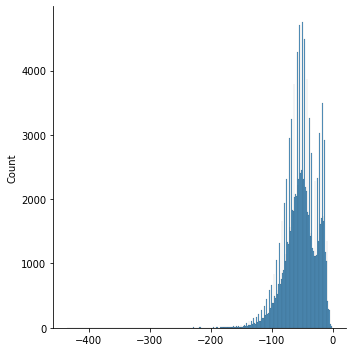

In [120]:
seaborn.displot(data=df["feat_area_Bright"] - df["feat_convex_area_Bright"])

In [121]:
%%time
sel1 = (df["feat_area_Bright"] - df["feat_convex_area_Bright"]) < -200
# core.plot_gate_czi(sel1, df, maxn=10, channel=3)

CPU times: user 999 µs, sys: 0 ns, total: 999 µs
Wall time: 800 µs


In [122]:
df = df[~sel1]
df.shape

(136619, 1291)

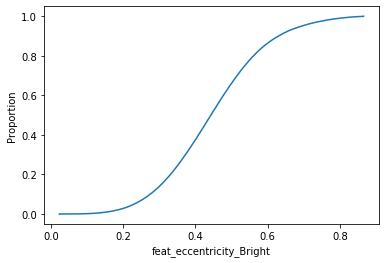

In [123]:
ax = seaborn.ecdfplot(data=df, x="feat_eccentricity_Bright")

In [124]:
sel1 = df["feat_eccentricity_Bright"] > 0.8
# core.plot_gate_czi(sel1, df, maxn=5, channel=3)

In [125]:
df = df[~sel1]
df.shape

(135309, 1291)

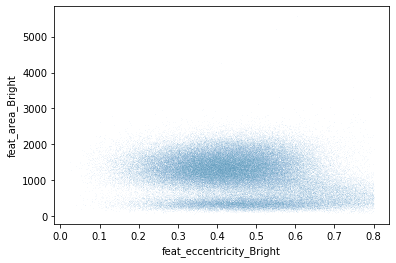

In [126]:
ax = seaborn.scatterplot(data=df, x="feat_eccentricity_Bright", y="feat_area_Bright", s=0.1, alpha=0.5)

# Noisy events

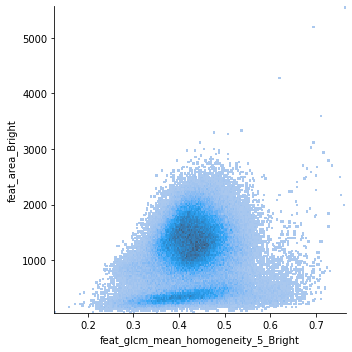

In [131]:
seaborn.displot(data=df, x="feat_glcm_mean_homogeneity_5_Bright", y="feat_area_Bright")

6 A1-A1 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
7 A1-A1 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
10 A1-A1 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
12 A1-A1 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
20 A1-A1 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
28 A1-A1 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
12 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
28 A5-A5 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
29 B10-B10 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
CPU times: user 40.1 s, sys: 11.6 s, total: 51.7 s
Wall time: 45.6 s


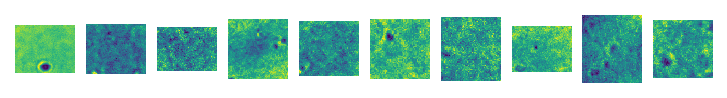

In [137]:
%%time
sel1 = df["feat_glcm_mean_homogeneity_5_Bright"] > 0.6
sel2 = df["feat_area_Bright"] > 2000
core.plot_gate_czi(sel1 & sel2, df, maxn=10, channel=3)

29 A1-A1 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
30 A1-A1 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
31 A1-A1 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
55 A1-A1 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
8 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
43 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
47 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
48 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
55 A3-A3 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
35 A5-A5 /data/gent/vo/000/gvo00070/vsc42015/datasets/CD7/images/plate_2_A1-A12+B9-B12.czi
CPU times: user 30.4 s, sys: 7.46 s, total: 37.9 s
Wall time: 33.4 s


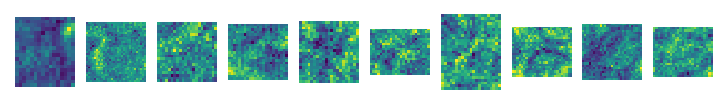

In [143]:
%%time
sel1 = df["feat_glcm_mean_homogeneity_5_Bright"] > 0.6
sel2 = df["feat_area_Bright"] < 1000
core.plot_gate_czi(sel1 & sel2, df, maxn=10, channel=3)

In [144]:
sel1 = df["feat_glcm_mean_homogeneity_5_Bright"] > 0.6
df = df[~sel1]
df.shape

(134239, 1291)

# Distributions

In [145]:
df = df.drop(columns=df.filter(regex="feat").columns[df.filter(regex="feat").var().isna()])
df.shape

(134239, 1291)

# Feature correlation

In [70]:
correlation = df.filter(regex="feat.*").corr()

## Overall feature correlation

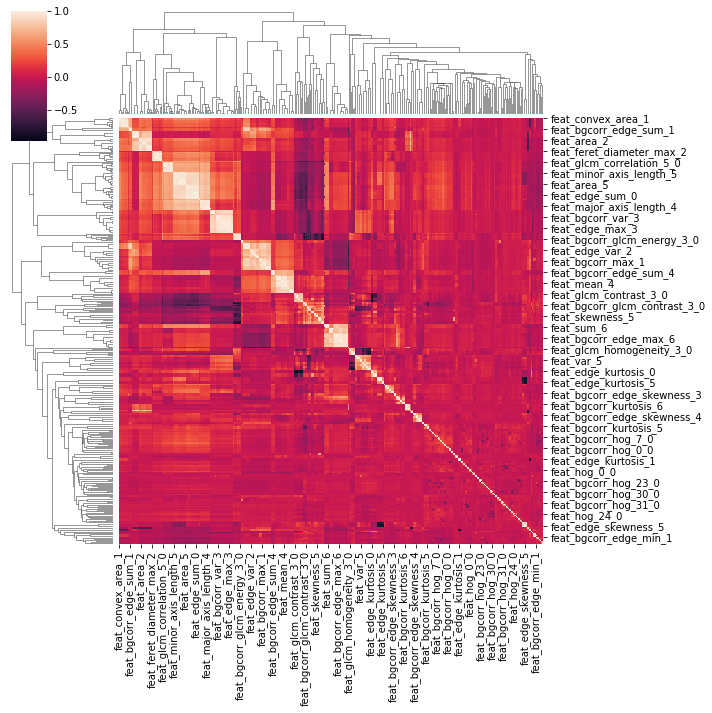

In [71]:
seaborn.clustermap(correlation)

In [157]:
def get_correlated_features(df, cutoff=0.85):
    correlation = df.corr()
    var = df.var()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > cutoff:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

In [158]:
correlated_features = get_correlated_features(df.filter(regex="feat"), cutoff=0.7)
correlation2 = df.filter(regex="feat").drop(columns=correlated_features).corr()

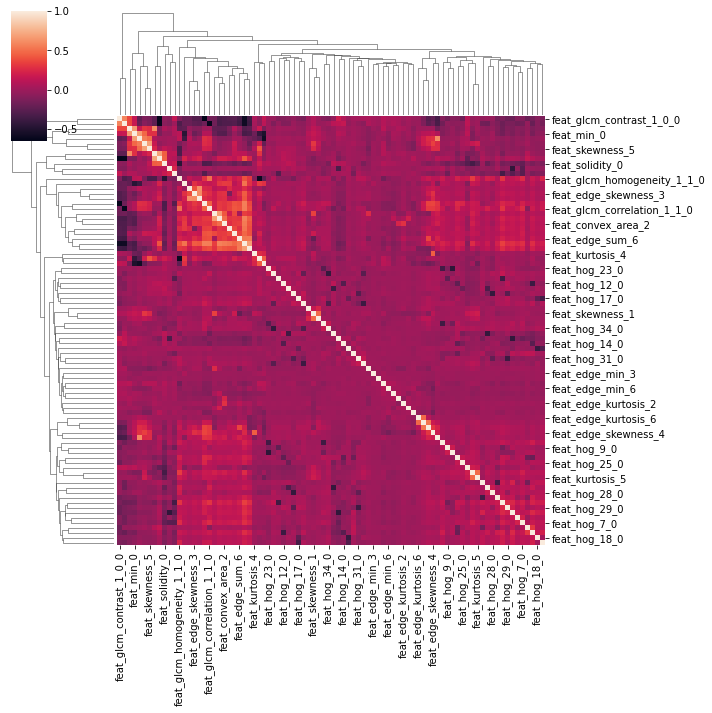

In [159]:
seaborn.clustermap(correlation2)

In [160]:
len(correlated_features)

153

In [161]:
df = df.drop(columns=correlated_features)

In [162]:
df.shape

(58440, 112)

In [163]:
len(df.index.values)

58440

# Export

In [232]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202111301629/single_focused_index.npy", df.index.values)

In [118]:
numpy.save("/data/gent/vo/000/gvo00070/vsc42015/datasets/weizmann/EhV/v2/results/scip/202112021107_dapi/columns.npy", df.columns.values)